# Classifier Certification -- Munging and Feature Extraction

##### IPython Autotime Magic

In [1]:
# External extension that allows us to time each block automagically
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Installed autotime.py. To use it, type:
  %load_ext autotime


/Users/keenan.hawekotte/anaconda/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


## Imports

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
% matplotlib inline

import numpy as np
import pandas as pd
import imageio as io
import os, sys
import math
import cPickle

time: 1.2 s


## Data loading functions

In [3]:
def unpickle(file):
    """
    Function to load and unpickle a given file and return a dict
    """
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def get_data_and_labels(folder, as_img=True, get_meta=True):
    """
    Takes in a folder location and outputs the images.
    Can output the image either as a vector or reformatted as a normal RGB image.
    Can also output metadata of images.
    """
    all_data = []
    all_labels = []
    meta = None
    for file in os.listdir(folder):
        if get_meta and 'meta' in file:
            meta = unpickle(os.path.join(folder, file))
        if not 'data_batch' in file:
            continue
        folder_plus_file = os.path.join(folder, file)
        dict = unpickle(folder_plus_file)
        if as_img:
            images = [to_img(img) for img in dict['data']]
        else:
            images = dict['data']
        all_data.extend(images)
        all_labels.extend(dict['labels'])
    if get_meta:
        return all_data, all_labels, meta
    else:
        return all_data, all_labels

def to_img(data):
    """
    Translates the CIFAR-10 image vectors into RGB images
    """
    img_array = np.zeros((32, 32, 3), dtype='uint8')
    index = 0
    
    for i in range(3):
        for j in range(32):
            for k in range(32):
                img_array[j,k,i] = data[index]
                index += 1
    return img_array

time: 28.2 ms


## Base and Classifier Classes

#### Base Class

In [11]:
class BaseModel:
    def name(self):
        return 'Base Model'
    
    def predict(self, x):
        # always predict background
        return 0
    
    # calculates the performance of the model
    def test(self, XY_test, display=True):
        ses = []
        tp = 0.
        tn = 0.
        fp = 0.
        fn = 0.
        for x, y in XY_test:
            pred = self.predict(x)
            ses.append(y**2.+pred**2.)
            if y == 1:
                if pred >= 0.5:
                    tp += 1
                else:
                    fn += 1
            else:
                if pred < 0.5:
                    tn += 1
                else:
                    fp += 1
        try:
            accuracy = (tp+tn)/(tp+tn+fp+fn)
        except:
            accuracy = np.nan
        try:
            recall = tp/(tp+fn)
        except:
            recall = np.nan
        try:
            precision = tp/(tp+fp)
        except:
            precision = np.nan
            
        results = {'mse': np.mean(ses), 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
        print "Fitted %s Results" % self.name()
        print "Accuracy: %0.2f%%" % (results['accuracy']*100.)
        print "Precision: %0.2f%%" % (results['precision']*100.)
        print "Recall: %0.2f%%" % (results['recall']*100.)
        return results
    
    # displays the model predictions on a grid for both test and training data
    # can also be used to save these plots to file
    def plot_model(self, XY_train, XY_test, display = True):
        x0es_test = {1: [], 0: []}
        x1es_test = {1: [], 0: []}
        for x, y in XY_test:
            x0es_test[y].append(x[0])
            x1es_test[y].append(x[1])

        x0es_train = {1: [], 0: []}
        x1es_train = {1: [], 0: []}
        for x, y in XY_train:
            x0es_train[y].append(x[0])
            x1es_train[y].append(x[1])

        x0min = min(x0es_test[0]+x0es_test[1])
        x0max = max(x0es_test[0]+x0es_test[1])
        x1min = min(x1es_test[0]+x1es_test[1])
        x1max = max(x1es_test[0]+x1es_test[1])

        numx0 = 50
        numx1 = int(np.ceil(numx0*(x1max-x1min)/(x0max-x0min)))
        dx0 = (x0max-x0min)/numx0
        dx1 = (x1max-x1min)/numx1
        values = np.zeros((numx1,numx0))
        for i in range(numx0):
            for j in range(numx1):
                x0 = x0min + i * dx0
                x1 = x1min + j * dx1
                values[j,i] = model.predict(np.asarray([x0,x1]))
                
        f, axarr = plt.subplots(1, 2, figsize=(16.,8.))
        the_extent = (x0min, x0max, x1min, x1max)

        axarr[0].plot(x0es_train[0], x1es_train[0], c='b', linestyle='None', marker='o')
        axarr[0].plot(x0es_train[1], x1es_train[1], c='r', linestyle='None', marker='o')
        axarr[0].imshow(values, cmap='bwr', interpolation='None', extent=the_extent, origin='lowerleft', alpha=1.0)
        axarr[0].set_title('%s (Train)' % model.name())

        axarr[1].plot(x0es_test[0], x1es_test[0], c='b', linestyle='None', marker='o')
        axarr[1].plot(x0es_test[1], x1es_test[1], c='r', linestyle='None', marker='o')
        axarr[1].imshow(values, cmap='bwr', interpolation='None', extent=the_extent, origin='lowerleft', alpha=1.0)
        axarr[1].set_title('%s (Test)' % model.name())

        if not display:
            plt.savefig('%s.jpg' % model.name())
        else:
            plt.show()

time: 161 ms


#### Decision Tree Class

In [12]:
class DecisionTree(BaseModel):
    def train(self, XY_train):
        print "Training is for losers who can't guess the correct answer!"
    
    def predict(self, x):
        if x[0] > 0.7*255:
            return 1 # frogs are green, let's say it's a frog
        elif x[1] > 0.5*255:
            return 0 # ships are blue-ish
        else:
            return 1 # I'm Nostradamus and it's a frog.

time: 3.14 ms


#### SVM Class

In [101]:
class SVM(BaseModel):
    def train(self, XY_train):
        # calculate normal vector
        self.w = np.average(np.array([x for x, y in XY_train if y==1]), axis=0) \
               - np.average(np.array([x for x, y in XY_train if y==0]), axis=0)

        # calculate offset term
        self.b = 1./len(XY_train)*sum([np.dot(self.w,x)-float(y) for x, y in XY_train])
    def predict(self, x):
        # get sign and then scale it to the range (0,1)
        prediction = (np.sign(np.dot(self.w,x)-self.b)+1)/2
        return prediction
    
    def name(self):
        return 'SVM'

time: 6.32 ms


#### kNN Class

In [104]:
class KNN(BaseModel):
    def train(self, XY_train, k=1):
        self.XY_train = XY_train
        self.k = k
    
    def predict(self, x):
        distance_label_list = [(np.linalg.norm(x-x_train), y_train) for x_train, y_train in self.XY_train]
        distance_label_list.sort()
        return np.average([label for distance, label in distance_label_list[:self.k]])
    
    def name(self):
        return 'kNN-%i' % self.k

time: 4.7 ms


#### Train Test Split Method

In [65]:
def train_test_split(image_data, labels, metadata, class_list, split=0.8, seed=None):
    if not seed:
        seed = 42
    np.random.seed(seed)
    
    df = pd.DataFrame(np.transpose([image_data, labels]), columns=['Data', 'Labels'])
    # Limit it to our wanted labels
    if type(class_list[0]) is int:
        df = df.loc[[x in set(class_list) for x in df.Labels]]
    else:
        df = df.loc[[meta['label_names'][x] in set(class_list) for x in df.Labels]]
    
    # Shuffle dataframe
    df = df.reindex(np.random.permutation(df.index))
    
    split_num = int(len(df) * split)
    train_df = df[:split_num]
    test_df = df[split_num:]
    return train_df.Data.values, train_df.Labels.values, test_df.Data.values, test_df.Labels.values

time: 8.28 ms


## Get the data

#### Download the dataset (OPTIONAL)
##### Note: this downloads the folder to the current working directory of your IPython kernel

In [ ]:
import urllib, tarfile
_ = urllib.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")
with tarfile.open("cifar-10-python.tar.gz", "r:gz") as tf:
    tf.extract('cifar-10-batches-py')

#### Import the data

In [4]:
#EXAMPLE:  data, labels, meta = get_data_and_labels('/Users/keenan.hawekotte/Downloads/cifar-10-batches-py/', as_img=True, get_meta=True)
data, labels, meta = get_data_and_labels('FILE/PATH/HERE', as_img=True, get_meta=True)
# Note: Images are 32x32x3 where R = 0, G = 1, B = 2

time: 35.1 s


#### Train and Test Splits

In [145]:
# Test and train data
train_X, train_Y, test_X, test_Y = train_test_split(data, labels, meta, ['frog', 'ship'])
# Setup the labels to correspond to 0 (frog/6) and 1 (ship/8)
norm_train_Y = np.array([0 if x ==6 else 1 for x in train_Y])
norm_test_Y = np.array([0 if x ==6 else 1 for x in test_Y])

time: 82.6 ms


#### Visualize an image

Ind: 8
Label: ship


/Users/keenan.hawekotte/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


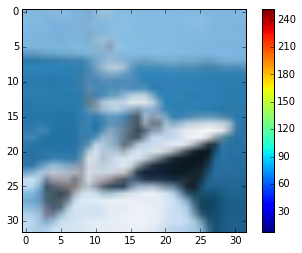

time: 293 ms


In [5]:
ind = 8  # Choose a random image to display

plt.imshow(data[ind])
plt.colorbar()
image = data[ind]

print 'Ind:', ind
print 'Label:', meta['label_names'][labels[ind]]

## Average color plotting

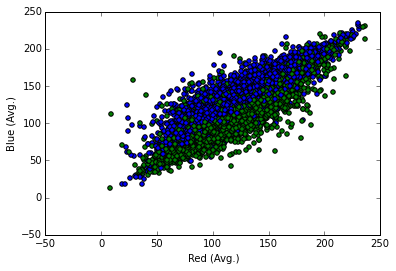

time: 28.3 s


In [6]:
# Plot Colors
fig = plt.figure()
ax = fig.add_subplot(111)
for ind, datum in enumerate(data):
    if meta['label_names'][labels[ind]] == 'ship':
        c = 'b'
    elif meta['label_names'][labels[ind]] == 'frog':
        c = 'g'
    else:
        continue
    tmp_image = datum
    red = np.average(tmp_image[:, :, 0])
    green = np.average(tmp_image[:, :, 1])
    blue = np.average(tmp_image[:, :, 2])
    # You can choose two of the following at any time to display: [hue, saturation, lightness]
    # Make sure you adjust the axes labels below accordingly
    ax.scatter(red, green, c=c)
ax.set_xlabel('Red (Avg.)')
ax.set_ylabel('Blue (Avg.)')

## Colors and Classifiers

In [80]:
# Green then Blue only
train_colors = tuple(np.transpose([[np.average(x[:, :, 1]) for x in train_X], [np.average(x[:, :, 2]) for x in train_X]]))
test_colors = tuple(np.transpose([[np.average(x[:, :, 1]) for x in test_X], [np.average(x[:, :, 2]) for x in test_X]]))

time: 241 ms


Fitted Base Model Results
Accuracy: 75.30%
Precision: 69.68%
Recall: 89.49%


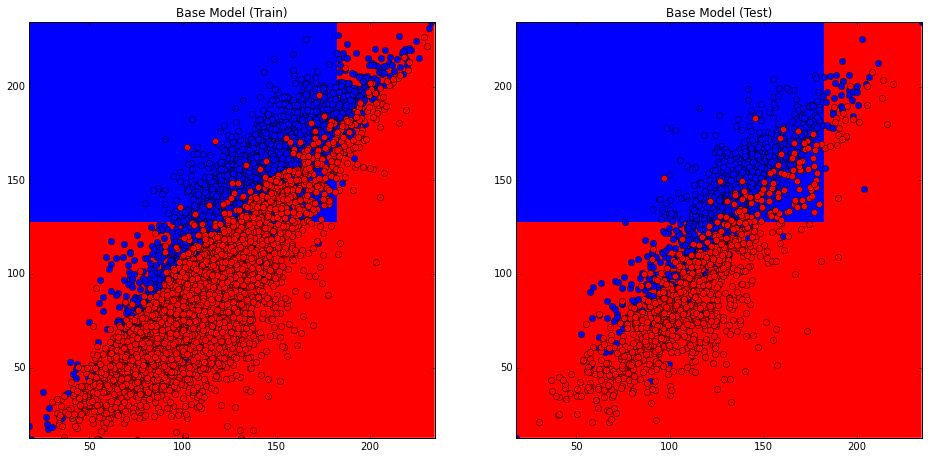

time: 589 ms


In [146]:
# Decision Tree
model = DecisionTree()
test_results = model.test(np.transpose((test_colors, 1-norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, 1-norm_train_Y)), np.transpose((test_colors, 1-norm_test_Y)), display=False)

Fitted SVM Results
Accuracy: 76.85%
Precision: 77.06%
Recall: 76.52%


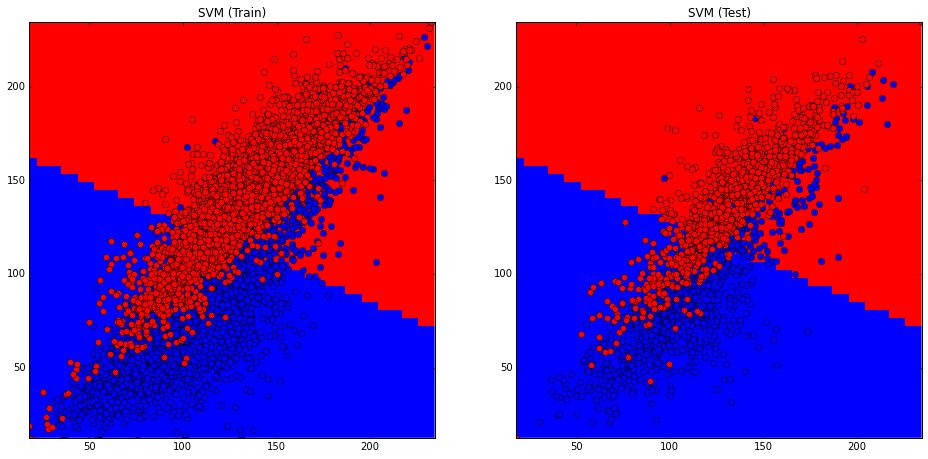

time: 461 ms


In [103]:
# SVM
model = SVM()
model.train(np.transpose((train_colors, norm_train_Y)))
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

Fitted kNN-1 Results
Accuracy: 82.65%
Precision: 82.83%
Recall: 82.42%


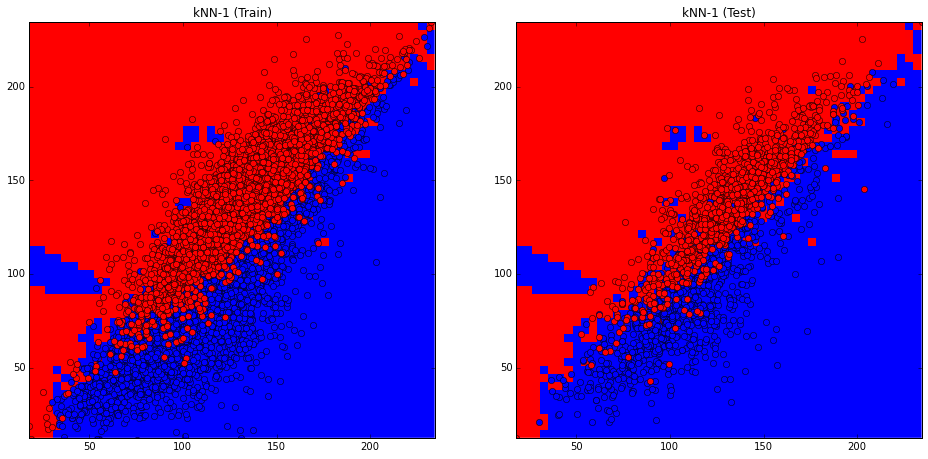

time: 4min 29s


In [105]:
# kNN-1
k = 1
model = KNN()
model.train(np.transpose((train_colors, norm_train_Y)), k)
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

Fitted kNN-10 Results
Accuracy: 86.45%
Precision: 85.03%
Recall: 88.51%


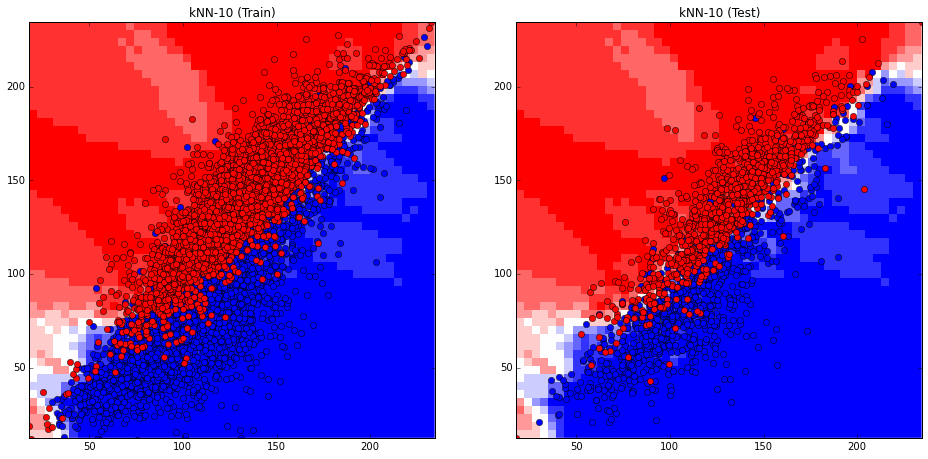

time: 4min 30s


In [106]:
# kNN-10
k = 10
model = KNN()
model.train(np.transpose((train_colors, norm_train_Y)), k)
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

Fitted kNN-100 Results
Accuracy: 86.20%
Precision: 85.02%
Recall: 87.91%


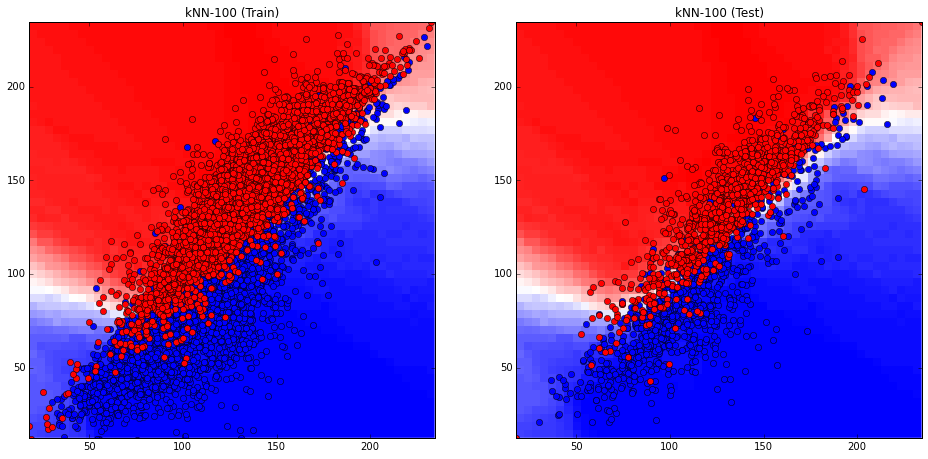

time: 4min 30s


In [107]:
# kNN-10
k = 100
model = KNN()
model.train(np.transpose((train_colors, norm_train_Y)), k)
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

## Plotting for H/S/L

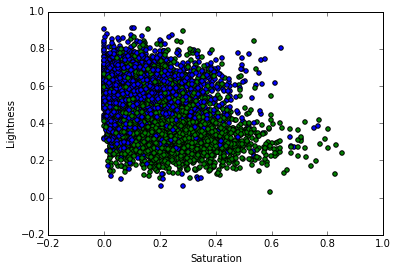

time: 32.3 s


In [7]:
# Plot HSL
fig = plt.figure()
ax = fig.add_subplot(111)
for ind, datum in enumerate(data):
    if meta['label_names'][labels[ind]] == 'ship':
        c = 'b'
    elif meta['label_names'][labels[ind]] == 'frog':
        c = 'g'
    else:
        continue
    tmp_image = datum
    red = tmp_image[:, :, 0]
    green = tmp_image[:, :, 1]
    blue = tmp_image[:, :, 2]
    hue = np.average(np.arctan2(((3)**(1/2)/2.) * (green - blue), 2*red - green - blue))
    lightness = np.average(0.5 * (np.min([np.average(red), np.average(green), np.average(blue)]) + 
                                  np.max([np.average(red), np.average(green), np.average(blue)]))) / 255.
    C = float(np.max([np.average(red), np.average(green), np.average(blue)]) - 
              np.min([np.average(red), np.average(green), np.average(blue)]))
    saturation = 0 if C==0 else C / (1 - np.abs(2*lightness - 1.)) / 255.
    # You can choose two of the following at any time to display: [hue, saturation, lightness]
    # Make sure you adjust the axes labels below accordingly
    ax.scatter(saturation, lightness, c=c)
ax.set_xlabel('Saturation')
ax.set_ylabel('Lightness')

## HSL and Classifiers

In [123]:
# Get the HSL values for the train and test sets
train_test_HSL = {'train': [], 'test': []}
for ind, tmp_data in enumerate([train_X, test_X]):
    for tmp_image in tmp_data:
        red = tmp_image[:, :, 0]
        green = tmp_image[:, :, 1]
        blue = tmp_image[:, :, 2]
        hue = np.average(np.arctan2(((3)**(1/2)/2.) * (green - blue), 2*red - green - blue))
        lightness = np.average(0.5 * (np.min([np.average(red), np.average(green), np.average(blue)]) + 
                                      np.max([np.average(red), np.average(green), np.average(blue)]))) / 255.
        C = float(np.max([np.average(red), np.average(green), np.average(blue)]) - 
                  np.min([np.average(red), np.average(green), np.average(blue)]))
        saturation = 0 if C==0 else C / (1 - np.abs(2*lightness - 1.)) / 255.
        if ind == 0:
            train_test_HSL['train'].append({'hue': hue, 'saturation': saturation, 'lightness': lightness})
        else:
            train_test_HSL['test'].append({'hue': hue, 'saturation': saturation, 'lightness': lightness})

time: 2.06 s


In [127]:
# Create the binary splits
train_HS = tuple(np.transpose([[x['hue'] for x in train_test_HSL['train'][:]], [x['saturation'] for x in train_test_HSL['train'][:]]]))
test_HS = tuple(np.transpose([[x['hue'] for x in train_test_HSL['test'][:]], [x['saturation'] for x in train_test_HSL['test'][:]]]))

train_SL = tuple(np.transpose([[x['saturation'] for x in train_test_HSL['train'][:]], [x['lightness'] for x in train_test_HSL['train'][:]]]))
test_SL = tuple(np.transpose([[x['saturation'] for x in train_test_HSL['test'][:]], [x['lightness'] for x in train_test_HSL['test'][:]]]))

train_HL= tuple(np.transpose([[x['hue'] for x in train_test_HSL['train'][:]], [x['lightness'] for x in train_test_HSL['train'][:]]]))
test_HL = tuple(np.transpose([[x['hue'] for x in train_test_HSL['test'][:]], [x['lightness'] for x in train_test_HSL['test'][:]]]))

time: 21.8 ms


Fitted Base Model Results
Accuracy: 50.05%
Precision: 50.05%
Recall: 100.00%


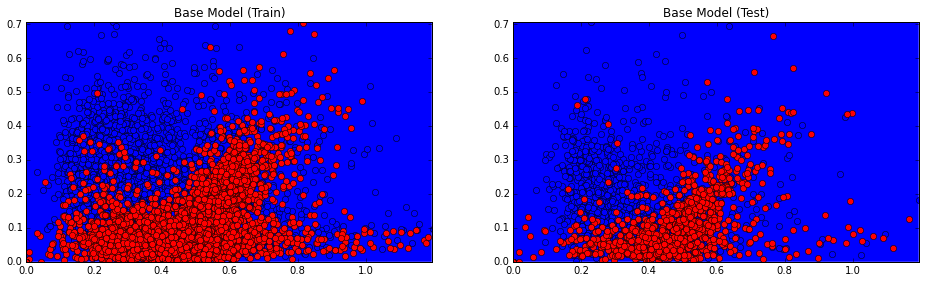

time: 524 ms


In [136]:
# Decision Tree
# HUE & SATURATION RIGHT NOW
model = DecisionTree()
test_results = model.test(np.transpose((test_HS, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_HS, norm_train_Y)), np.transpose((test_HS, norm_test_Y)), display=False)

Fitted SVM Results
Accuracy: 50.05%
Precision: 50.05%
Recall: 100.00%


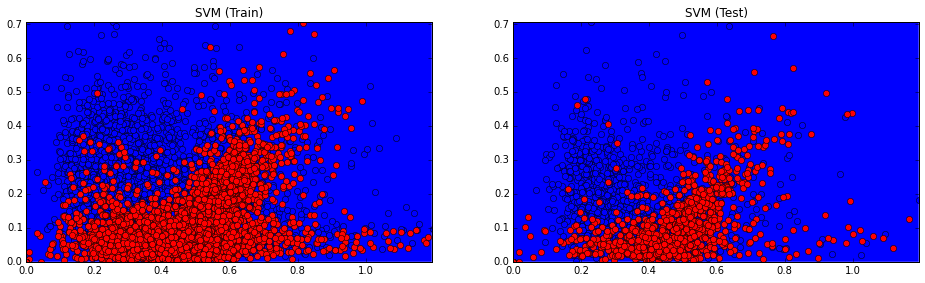

time: 416 ms


In [138]:
# SVM
# HUE & SATURATION
model = SVM()
model.train(np.transpose((train_HS, norm_train_Y)))
test_results = model.test(np.transpose((test_HS, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_HS, norm_train_Y)), np.transpose((test_HS, norm_test_Y)), display=True)

Fitted kNN-1 Results
Accuracy: 69.40%
Precision: 69.75%
Recall: 68.63%


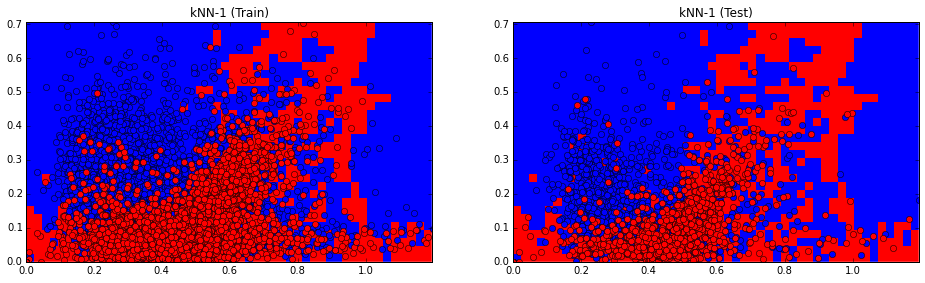

time: 3min 9s


In [142]:
# kNN-1
# HUE & SATURATION
k = 1
model = KNN()
model.train(np.transpose((train_HS, norm_train_Y)), k)
test_results = model.test(np.transpose((test_HS, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_HS, norm_train_Y)), np.transpose((test_HS, norm_test_Y)), display=True)

Fitted kNN-10 Results
Accuracy: 76.95%
Precision: 72.77%
Recall: 86.21%


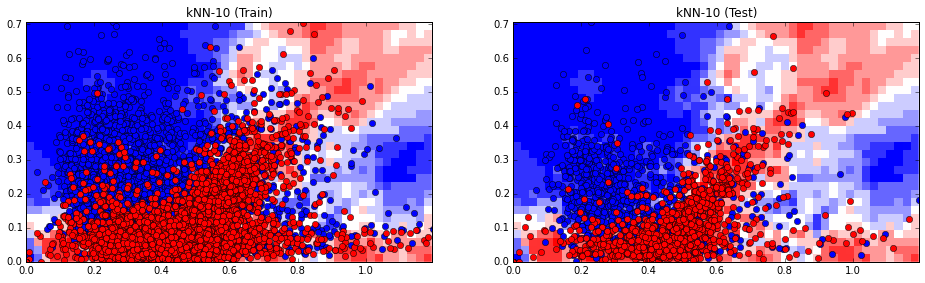

time: 3min 8s


In [139]:
# kNN-10
# HUE & SATURATION
k = 10
model = KNN()
model.train(np.transpose((train_HS, norm_train_Y)), k)
test_results = model.test(np.transpose((test_HS, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_HS, norm_train_Y)), np.transpose((test_HS, norm_test_Y)), display=True)

Fitted kNN-50 Results
Accuracy: 78.85%
Precision: 74.96%
Recall: 86.71%


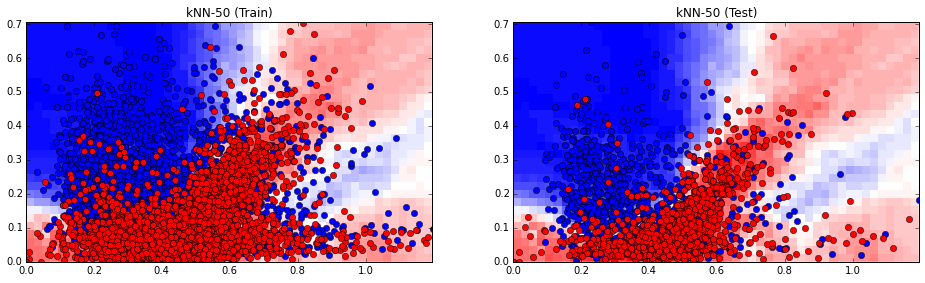

time: 3min 9s


In [143]:
# kNN-50
# HUE & SATURATION
k = 50
model = KNN()
model.train(np.transpose((train_HS, norm_train_Y)), k)
test_results = model.test(np.transpose((test_HS, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_HS, norm_train_Y)), np.transpose((test_HS, norm_test_Y)), display=True)

Fitted kNN-100 Results
Accuracy: 79.00%
Precision: 74.47%
Recall: 88.31%


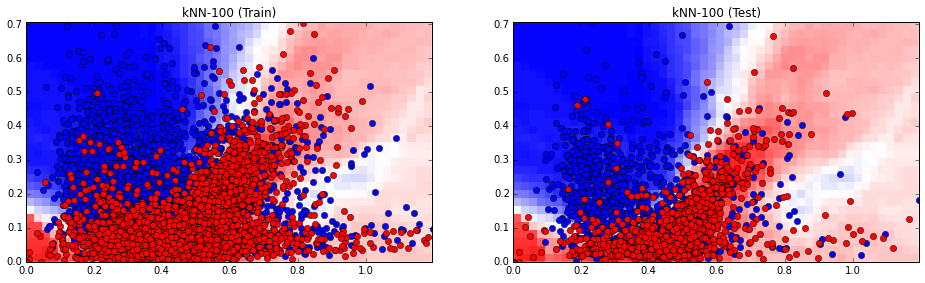

time: 3min 10s


In [144]:
# kNN-100
# HUE & SATURATION
k = 100
model = KNN()
model.train(np.transpose((train_HS, norm_train_Y)), k)
test_results = model.test(np.transpose((test_HS, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_HS, norm_train_Y)), np.transpose((test_HS, norm_test_Y)), display=True)

## Color Histograms

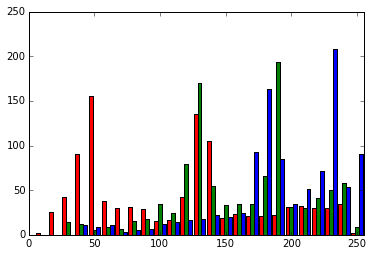

time: 269 ms


In [8]:
# Bins by 10 to 255
colors = [None, None, None]
bins = np.array(range(0, 255, 10)) # left inclusive, right non-inclusive
for color in xrange(image.shape[2]):
    counts = np.zeros(len(bins))
    for pixel in image[:, :, color].flatten():
        locs = np.where(bins - pixel >= 0)[0]
        if len(locs) == 0:
            counts[-1] += 1
        else:
            counts[min(locs)] += 1
    colors[color] = counts
colors = np.array(colors)

ax = plt.subplot(111)
offset = 3
ax.bar(bins - offset, colors[0], width=offset, color='r', align='center')
ax.bar(bins, colors[1], width=offset, color='g', align='center')
ax.bar(bins + offset, colors[2], width=offset, color='b', align='center')
ax.set_xlim(0, 255)
plt.show()

## Image Normalization

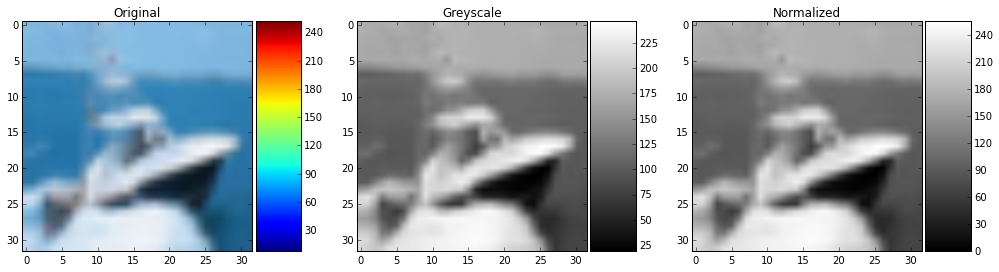

time: 652 ms


In [9]:
# Image Normalization
greyscale = np.dot(image[...,:3], [0.299, 0.587, 0.114])
wanted_range = [0, 255]
image_range = [np.min(greyscale.flatten()), np.max(greyscale.flatten())]
norm_im = (greyscale - image_range[0]) * (wanted_range[1] - wanted_range[0]) / (image_range[1] - image_range[0]) + wanted_range[0]

# Plooooooot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 9))
axes[0].set_title('Original')
im1 = axes[0].imshow(image)
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="20%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

axes[1].set_title('Greyscale')
im2 = axes[1].imshow(greyscale, cmap=plt.cm.gray)
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="20%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

axes[2].set_title('Normalized')
im3 = axes[2].imshow(norm_im, cmap=plt.cm.gray)
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="20%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

## Histogram Equalization

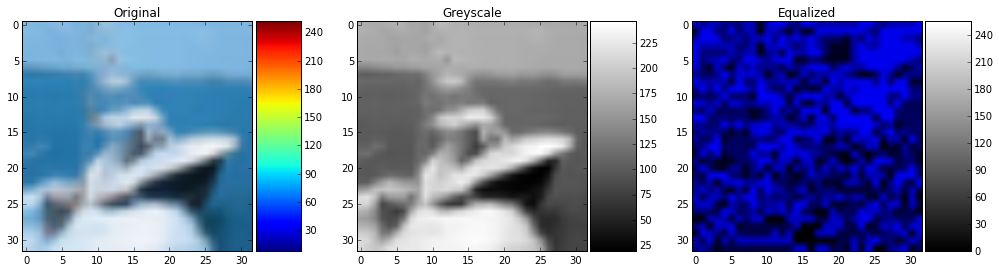

time: 698 ms


In [10]:
# Histogram equalization
num_colors = 256
bins = range(num_colors)
eq_im = np.zeros(image.shape)
counts = np.zeros(len(bins))
for pixel in np.dot(image[...,:3], [0.299, 0.587, 0.114]).flatten():
    locs = np.where(bins - pixel >= 0)[0]
    if len(locs) == 0:
        counts[-1] += 1
    else:
        counts[min(locs)] += 1
counts = np.array(counts) / float(np.max(counts))
cdf = np.array([x if ind == 0 else x + np.sum(counts[:ind]) for ind, x in enumerate(counts)])
norm_cdf = 255. * cdf / cdf[-1]
eq_im[:, :, color] = np.interp(image[:, :, color].flatten(), bins[:-1], norm_cdf[:-1]).reshape(image[:, :, color].shape)

# Plooooooot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 9))
axes[0].set_title('Original')
im1 = axes[0].imshow(image)
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="20%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

axes[1].set_title('Greyscale')
im2 = axes[1].imshow(greyscale, cmap=plt.cm.gray)
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="20%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

axes[2].set_title('Equalized')
im3 = axes[2].imshow(eq_im, cmap=plt.cm.gray)
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="20%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

##### ^^ Not too effective for this, eh?

# Homework:
##### Submit to @have_uh_cot_ee or [keenan.hawekotte@hudl.com](keenan.hawekotte@hudl.com)

### 1) Boolean Features
Identify at least five non-color related boolean features that are related to the images and run them through a decision tree. Post your features and outputs.

### 2) Numerical Features
Identify (or utilize) three numerical features and run them through a model of your choice (*cough* kNN *cough*). The chosen features must not be all colors or HSV values. Post the features and outputs.

### 3) Color Gradient
Extend the color gradient to at least ten bins. Identify the bins and plot at least one image of the bins for a frog and one for a ship. Post bins and images.

### Bonus) 
Using whatever method you want, run an image through an HoG transform. Post the before and after.